# Collect all links and text of articles

In [183]:
#from wikitools2 import wiki, api #new version of wikitools
from wikitools import wiki, api
import urllib, json
import re, urlparse
import pprint
import mwparserfromhell
from mwparserfromhell.nodes import Wikilink
import pandas as pd

def load_simple_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)
    
def check_categories(page):
    categories_f=["Kategorie:Frau"]
    categories_m=["Kategorie:Mann"]
    #http://de.wikipedia.org/w/api.php?action=query&titles=Hebamme&prop=categories
    l="de" 
    site = wiki.Wiki("http://"+l+".wikipedia.org/w/api.php")
    params={'action':'query','titles':page,'prop':'categories','format':'json','continue':'','redirects':''}
    request = api.APIRequest(site, params)
    for result in request.queryGen():
        if result["query"]["pages"].values()[0].get("categories"):
            for i in result["query"]["pages"].values()[0]["categories"]:
                if i["title"] in categories_f:
                    return "Frau" 
                elif i["title"] in categories_m:
                    return "Mann"   
        else:
            return None   
    return None
def query_de_wiki(site,params):
    req = api.APIRequest(site, params)
    res=req.query()
    return res["query"]["pages"][0]["extract"]
    
def get_links_from_text(title):   
    language="de"
    site = wiki.Wiki("http://" + language + ".wikipedia.org/w/api.php")
    params = {'action':'parse', 'page':title, 'prop':'wikitext'}
    req = api.APIRequest(site, params) 
  
    alllinklist = []
    male_person=[]
    female_person=[]
    all_text=""
    lead_text=""
    
    #store all raw text
    params={'action':'query','titles':title,'prop':'extracts','explaintext':'','redirects':'','formatversion':'2'}
    all_text=query_de_wiki(site,params)
            
    #store lead raw text
    params['exintro']=''
    lead_text=query_de_wiki(site,params)
            
    if True:
        #try:
        #res= req.query(querycontinue=False) #False ?
        for res in req.queryGen():
            #wiki text with links and text as wiki markup language
            text = res['parse']['wikitext']['*']
            #a=mwparserfromhell.parse(text)
            #print a.strip_code()

            #parse all links
            filtered_code = mwparserfromhell.parse(text).filter_wikilinks()
            for node in filtered_code: 
                link = node.title
                if ":" not in link:
                    if link is not None:
                        strlink = link.encode("utf-8").decode("utf-8").replace(' ', '_')
                        # strlink=urllib.quote(strlink.encode("utf-8"))
                        if strlink not in alllinklist:
                            alllinklist.append(strlink)
                            #Kategorie:Frau, Kategorie:Mann
                            #check the category of the link
                            gender=check_categories(strlink)
                            if gender =="Mann":
                                male_person.append(strlink)
                            elif gender=="Frau":
                                female_person.append(strlink)
                                

        return alllinklist,male_person,female_person,all_text,lead_text  
            
Dump = {} 
data=pd.read_csv("de/wiki/all_wiki_pages.csv",sep='\t', encoding='utf-8',index_col=0)   
pages=data.WikiName.values   
with open('de/wiki/all_data_from pages.json', 'r') as in_f:
    Dump=json.load(in_f)
print "We already stored", len(Dump), "professions", "out of ",len(pages)
#pages=["Gleichstellungsbeauftragte","Lehrer","Arzt"]
for title in pages:
    if title not in Dump:
        alllink,m,f,all_text,lead_text = get_links_from_text( title)
        print len(alllink)
        Dump.update({title:{"all_link":alllink,"male_person":m,"female_person":f,"male_person_amount":len(m),
                                "female_person_amount":len(f),"text":all_text,"lead":lead_text}})             

We already stored 885 professions out of  885


In [13]:
with open('de/wiki/all_data_from pages.json', 'w') as out:
    json.dump(Dump, out, indent=4, sort_keys=True)  

#links to Wiki API all plane text and lead
https://de.wikipedia.org/w/api.php?action=query&prop=extracts&titles=Gleichstellungsbeauftragte&exintro=&explaintext=&redirects=&exsentences=10&formatversion=2

https://de.wikipedia.org/w/api.php?action=query&prop=extracts&titles=Gleichstellungsbeauftragte&exintro=&explaintext=&redirects=&formatversion=2

# Analysis

In [201]:
import pandas as pd
import json

data=pd.read_csv("de/wiki/all_wiki_pages.csv",sep='\t', encoding='utf-8',index_col=0) 
with open('de/wiki/all_data_from pages.json', 'r') as in_f:
    Dump=json.load(in_f)

In [202]:
df=pd.DataFrame.from_dict(Dump,orient="index")#885
df.describe()

,male_person_amount,female_person_amount
count,885.000000,885.000000
mean,3.033898,0.392090
std,12.024531,2.585406
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,161.000000,61.000000


Populating the interactive namespace from numpy and matplotlib


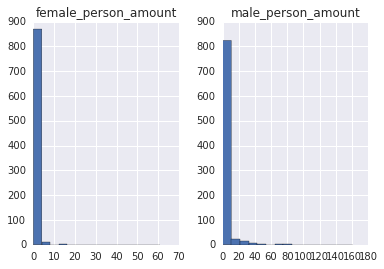

In [203]:
%pylab inline
g=df.hist(bins=15)


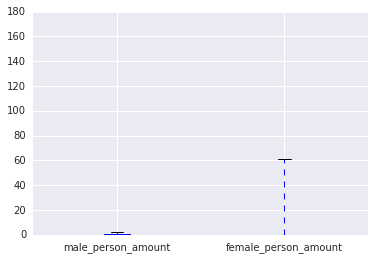

In [204]:
df.boxplot(return_type='axes')

# Remove data where there is no persons at all

In [205]:
#Remove data where there is no male person neither female  simultaneously
df_0=df[(df.male_person_amount==0)& (df.female_person_amount==0)]#628
df=df[(df.male_person_amount>0)| (df.female_person_amount>0)]#257
print "There are ",len(df),"profesions with at least one person"
df.describe()

There are  257 profesions with at least one person


,male_person_amount,female_person_amount
count,257.000000,257.000000
mean,10.447471,1.350195
std,20.531183,4.667241
min,0.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,10.000000,1.000000
max,161.000000,61.000000


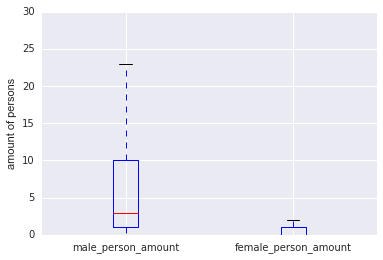

In [208]:
g=df.boxplot(return_type='axes')
plt.ylim(0,30)
#plt.xlabel("n=257")
plt.ylabel("amount of persons")
plt.show()

Mean of male person ratio:  0.86312298299


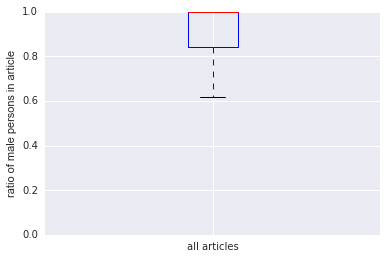

In [195]:
df["m_normalized"]=df.apply(lambda x: float(x["male_person_amount"])/float(x["male_person_amount"] + x["female_person_amount"]), axis = 1)
g=df.boxplot(column="m_normalized", return_type="axes")
plt.xticks([1],["all articles"])
plt.ylabel("ratio of male persons in article")
print "Mean of male person ratio: ",df.m_normalized.mean()

### bias

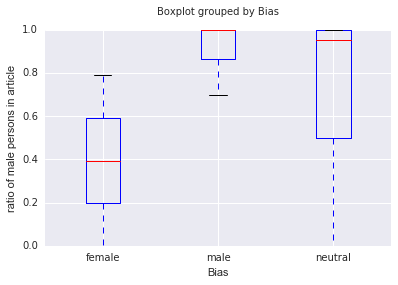

In [111]:
#=====we do not use this data
#df2_f=df2[df2.index.isin(data[data.Bias=="female"].WikiName)]#female bias n=2
#df2_f["Bias"]="female"#pd.Series("female", index=df2_f.index)
#df2_m=df2[df2.index.isin(data[data.Bias=="male"].WikiName)]#male bias n=234
#df2_m["Bias"]="male"
#df2_n=df2[df2.index.isin(data[data.Bias=="neutral"].WikiName)]#neutral n=21
#df2_n["Bias"]="neutral"
#========end

df["Bias"]=df.apply(lambda x: data[data.WikiName.isin([x.name])].Bias.values[0], axis =1)
g=df.boxplot(by='Bias',column="m_normalized", return_type="axes")
plt.ylabel("ratio of male persons in article")
plt.title("")
plt.show()
#plt.xticks(range(1,4),["female\nn=2","male\nn=234","neutral\nn=21"])

In [112]:
#significance test
from scipy import stats  

m_val=df[df.Bias=="male"].m_normalized.values
f_val=df[df.Bias=="female"].m_normalized.values
n_val=df[df.Bias=="neutral"].m_normalized.values
z_stat, p_val = stats.ranksums(m_val, f_val)   
print "MWW RankSum P for male and female distributions =", p_val , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(m_val, n_val)   
print "MWW RankSum P for male and neutral distributions =", p_val , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(f_val, n_val)   
print "MWW RankSum P for female and neutral distributions =", p_val , "z_stat=",z_stat
all_together=list(m_val)+ list(f_val)+ list(n_val)
z_stat, p_val = stats.ranksums(all_together, m_val)  
print "MWW RankSum P for all together and male distributions =", p_val ,"z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, f_val)  
print "MWW RankSum P for all together and female distributions =", p_val  , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, n_val)  
print "MWW RankSum P for all together and neutral distributions =", p_val  , "z_stat=",z_stat

MWW RankSum P for male and female distributions = 0.0583495821864 z_stat= 1.89306232089
MWW RankSum P for male and neutral distributions = 0.135760959059 z_stat= 1.49176424978
MWW RankSum P for female and neutral distributions = 0.190430263826 z_stat= -1.30930734142
MWW RankSum P for all together and male distributions = 0.671929209717 z_stat= -0.423501766874
MWW RankSum P for all together and female distributions = 0.0660133910361 z_stat= 1.83833272978
MWW RankSum P for all together and neutral distributions = 0.183637772329 z_stat= 1.32963739097


### gender of profession label

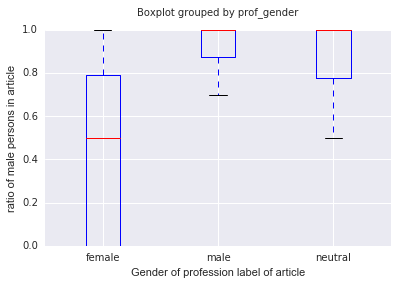

In [116]:
import copy
f_val=load_simple_json('de/wiki/f_page_validated.json')
f_amb=load_simple_json('de/wiki/f_page_ambigious.json')
n_pages=load_simple_json('de/wiki/n_page_validated.json')
n_pages2=data[(data.Bias=="neutral") & (data.Name!=data.WikiName)].WikiName.values#neutral names of professions
n_pages_all=copy.deepcopy(n_pages)
n_pages_all.extend(n_pages2)
f_val_all=copy.deepcopy(f_val)
f_val_all.extend(f_amb)


#add column "profession gender" to DataFrame
def identify_gender(f_val_all,n_pages_all,x):
    if x.name in f_val_all:
        return "female"
    elif x.name in n_pages_all:
        return "neutral"
    else:
        return "male"
df["prof_gender"]=df.apply(lambda x: identify_gender(f_val_all,n_pages_all,x),axis=1)


g=df.boxplot(column="m_normalized",by="prof_gender",return_type='axes')#n=9,n=239,n=9
plt.title("")
plt.ylabel("ratio of male persons in article")
plt.xlabel("Gender of profession label of article")
plt.show()

In [117]:
#significance test:

#significance test
from scipy import stats  

m_val=df[df.prof_gender=="male"].m_normalized.values
f_val=df[df.prof_gender=="female"].m_normalized.values
n_val=df[df.prof_gender=="neutral"].m_normalized.values
z_stat, p_val = stats.ranksums(m_val, f_val)   
print "MWW RankSum P for male and female distributions =", p_val , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(m_val, n_val)   
print "MWW RankSum P for male and neutral distributions =", p_val , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(f_val, n_val)   
print "MWW RankSum P for female and neutral distributions =", p_val , "z_stat=",z_stat
all_together=list(m_val)+ list(f_val)+ list(n_val)
z_stat, p_val = stats.ranksums(all_together, m_val)  
print "MWW RankSum P for all together and male distributions =", p_val ,"z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, f_val)  
print "MWW RankSum P for all together and female distributions =", p_val  , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, n_val)  
print "MWW RankSum P for all together and neutral distributions =", p_val  , "z_stat=",z_stat

MWW RankSum P for male and female distributions = 0.00374126834659 z_stat= 2.89919106346
MWW RankSum P for male and neutral distributions = 0.555656718844 z_stat= 0.589304959022
MWW RankSum P for female and neutral distributions = 0.0850890728162 z_stat= -1.72189206418
MWW RankSum P for all together and male distributions = 0.644026063252 z_stat= -0.462077055792
MWW RankSum P for all together and female distributions = 0.00533806767724 z_stat= 2.78589185896
MWW RankSum P for all together and neutral distributions = 0.643474786722 z_stat= 0.46284595758


### Labor market

156
 93
No statistical data for these profesions:
[u'Trainer', u'Angestellter', u'Sachverst\xe4ndiger', u'Sonnenschutztechniker', u'Steinhauer', u'B\xfcchsenmeister', u'Helfer', u'Mediaberater']


[]

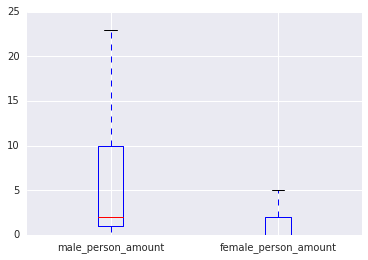

In [142]:
all_together=pd.read_csv("de/all_labour.csv",sep='\t', encoding='utf-8',index_col=0) 

#male
df_most_m=all_together[all_together.Frauen<50.0]
#wikipedia page names for male dominated professions
m_=list(data[data.Name.isin(df_most_m.name)].WikiName.values) #529
m_m=list(data[data.Oppositgender.isin(df_most_m.name)].WikiName.values) #6
m_.extend(m_m)#535
male_most_people=df[df.index.isin(m_)]#156
print len(male_most_people)


#female
#get where more than 50% of women involved
df_most_f=all_together[all_together.Frauen>=50.0]#308
f_=list(data[data.Name.isin(df_most_f.name)].WikiName.values) #297
f_f=list(data[data.Oppositgender.isin(df_most_f.name)].WikiName.values) #12
f_.extend(f_f)#309
female_most_people=df[df.index.isin(f_)]#93
print "",len(female_most_people)

print "No statistical data for these profesions:"
print list(set(set(df.index)-set(m_))-set(f_))


g=female_most_people.boxplot(return_type='axes',column=["male_person_amount","female_person_amount"])
g.set_ylim(0,25)
#g.set_xticks([1,2],["male persons","female persons"])
g.plot()

[]

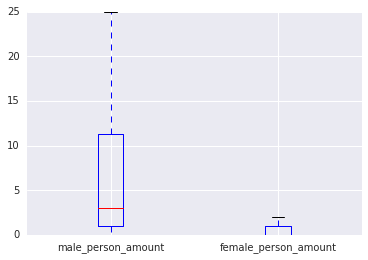

In [132]:
g=male_most_people.boxplot(return_type='axes',column=["male_person_amount","female_person_amount"])
g.set_ylim(0,25)
g.plot()

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


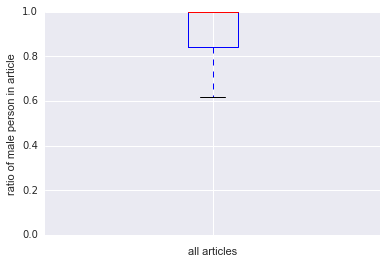

Ratio of male persons in all articles (mean): 0.864247416179


In [143]:
male_most_people["labor_market_domin"]=male_most_people.apply(lambda x: "male",axis=1)#"male"
female_most_people["labor_market_domin"]=female_most_people.apply(lambda x: "female",axis=1)#"female"


#all data
df_all=pd.concat([male_most_people,female_most_people],ignore_index=True)
df_all.boxplot(column="m_normalized",return_type='axes')
plt.xlabel("all articles")
plt.xticks([1],"")
plt.ylabel("ratio of male person in article")
plt.show()
print "Ratio of male persons in all articles (mean):",df_all.m_normalized.mean()


Ratio of male persons in articles about female dominated profesion(mean): 0.831424938451
Ratio of male persons in articles about male dominated profesion(mean): 0.883814662517


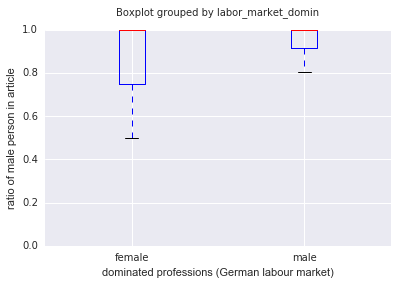

In [95]:
m_val=df_all[df_all.labor_market_domin=="male"].m_normalized.values
f_val=df_all[df_all.labor_market_domin=="female"].m_normalized.values
g_b_m=df_all.boxplot(column="m_normalized",return_type='axes',by="labor_market_domin")
plt.title("")#"ratio of men in artcles for professions where there are less than 50% female")
plt.xlabel("dominated professions (German labour market)")
plt.ylabel("ratio of male person in article")
print "Ratio of male persons in articles about female dominated profesion(mean):",df_all[df_all.labor_market_domin=="female"].m_normalized.mean()
print "Ratio of male persons in articles about male dominated profesion(mean):",df_all[df_all.labor_market_domin=="male"].m_normalized.mean()

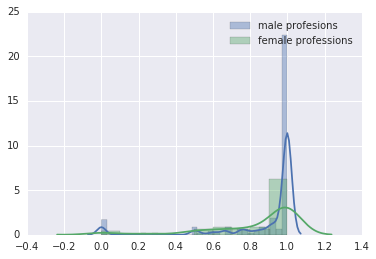

In [96]:
g1=sns.distplot(m_val,label="male profesions")
g2=sns.distplot(f_val,label="female professions")
g2.legend()
#g.set_xlim(0,)

In [80]:
from scipy import stats  
  
z_stat, p_val = stats.ranksums(m_val, f_val)   
print "MWW RankSum P for male and female distributions =", p_val , "z_stat=",z_stat
all_together=list(m_val)+ list(f_val)
z_stat, p_val = stats.ranksums(all_together, m_val)  
print "MWW RankSum P for all together and male distributions =", p_val ,"z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, f_val)  
print "MWW RankSum P for all together and female distributions =", p_val  , "z_stat=",z_stat

MWW RankSum P for male and female distributions = 0.0293931605355 z_stat= 2.1781729848
MWW RankSum P for all together and male distributions = 0.296217739688 z_stat= -1.04457867523
MWW RankSum P for all together and female distributions = 0.141048220492 z_stat= 1.47189875267


## Distribution visualisation

(0, 200.0)

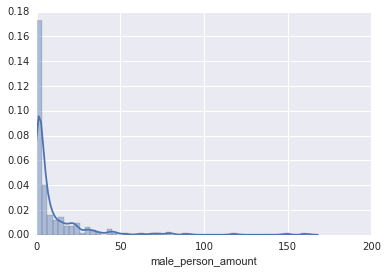

In [39]:
import seaborn as sns
#sns.set(color_codes=True)
g=sns.distplot(df.male_person_amount)
g.set_xlim(0,)

(0, 70.0)

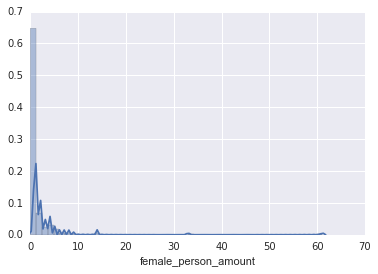

In [40]:
g=sns.distplot(df.female_person_amount)
g.set_xlim(0,)

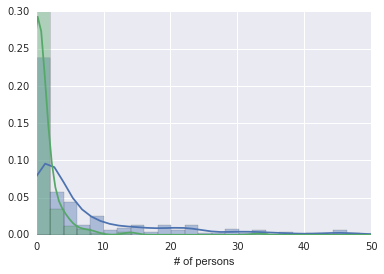

In [41]:
g1=sns.distplot(df.male_person_amount,bins=80)
g2=sns.distplot(df.female_person_amount,bins=30, kde_kws={"bw":1})
g1.set_xlim(0,50)
g1.set_ylim(0,0.3)
g1.set_xlabel("# of persons")

### Comulative distribution

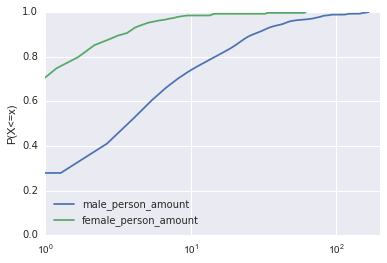

In [42]:
g=sns.kdeplot(df.male_person_amount,cumulative=True)#,linestyle="dotted")
g1=sns.kdeplot(df.female_person_amount,cumulative=True)
#g.set_ylim(1, 0)
g.set_xlim(1,)
g.set_xscale('log')
g.set_ylabel("P(X<=x)")

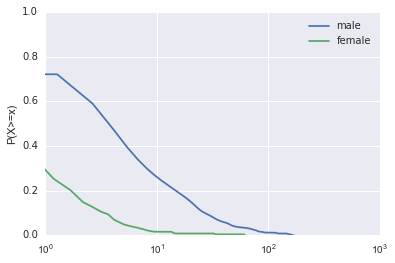

In [43]:
line = g.lines[0]
plt.plot(line.get_xdata(),1-line.get_ydata(), label="male")
line2=g.lines[1]
plt.plot(line2.get_xdata(),1-line2.get_ydata(), label="female")
plt.xscale("log")
plt.xlim(1,)
plt.legend()
plt.ylabel("P(X>=x)")

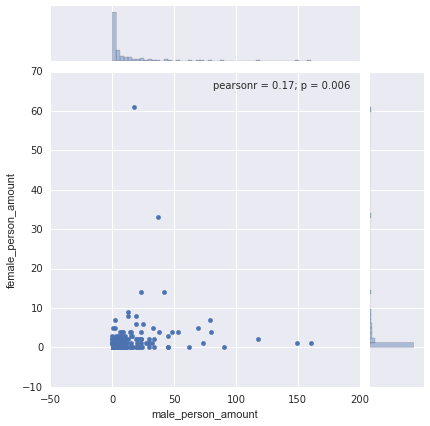

In [44]:
g=sns.jointplot(x="male_person_amount", y="female_person_amount", data=df);

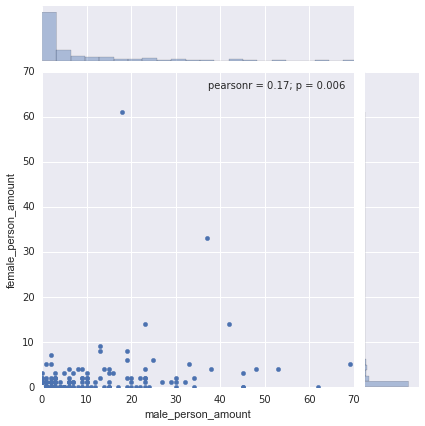

In [45]:
g=sns.jointplot(x="male_person_amount", y="female_person_amount",data=df, xlim=(0,70), ylim=(0,70))

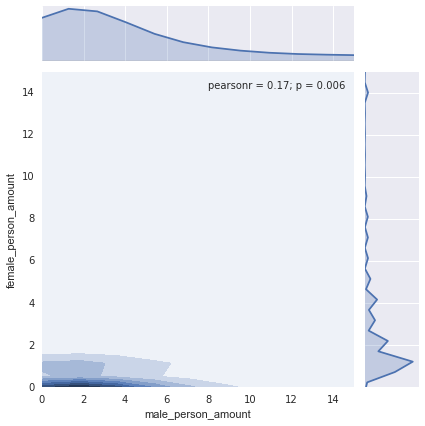

In [46]:
g=sns.jointplot(x="male_person_amount", y="female_person_amount",data=df, kind="kde",xlim=(0,15), ylim=(0,15))
#g.plot_joint(plt.scatter, c="black", s=30, linewidth=1, marker="+")

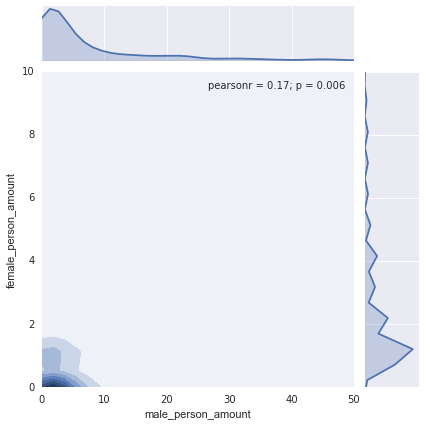

In [47]:
g=sns.jointplot(x="male_person_amount", y="female_person_amount",data=df, kind="kde",xlim=(0,50), ylim=(0,10))
#g.plot_joint(plt.scatter, c="black", s=30, linewidth=1, marker="+")

89


(0, 70.0)

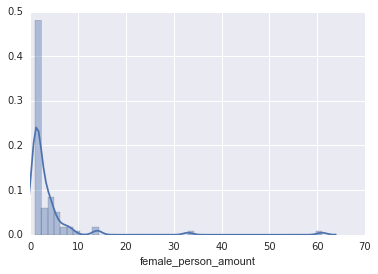

In [48]:
#del all where female zero
df3=df[(df.male_person_amount!=0) & (df.female_person_amount!=0)]#89
print len(df3)
g=sns.distplot(df3.female_person_amount)
g.set_xlim(0,)

# Analysis of text (nltk)

In [1]:
import nltk
#nltk.download()
print(nltk.__version__)

3.1


In [21]:
import nltk
from nltk.tree import Tree
import re

def identify_person_in_text(text):
    person_list = []
    for sentence in nltk.sent_tokenize(text):
        #print sentence
        sent1 = nltk.word_tokenize(sentence)
        sent2 = nltk.pos_tag(sent1)
        sent3 =  nltk.ne_chunk(sent2,binary = False)#, binary=True)
        #print sent3
        #sent3.draw()
        person_list.append(re.findall(r'PERSON\s(.*?)/',str(sent3)))
    return person_list
def identify_person_in_text2(text):
    person_list = []
    for sent in nltk.sent_tokenize(text):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))).subtrees(filter=lambda t: t.label() == 'PERSON'):
            person_list.append(' '.join(c[0] for c in chunk.leaves()))
    return person_list

def identify_person_in_text3(text):
    person_list = []
    for sentence in nltk.sent_tokenize(text):
        #print sentence
        sent1 = nltk.word_tokenize(sentence)
        sent2 = nltk.pos_tag(sent1)
        sent3 =  nltk.ne_chunk(sent2,binary = False)#, binary=True)
        person = []
        name = ""
        for subtree in sent3.subtrees(filter=lambda t: t.label() == 'PERSON'):
            for leaf in subtree.leaves():
                person.append(leaf[0])
                #print person
            if len(person) > 1: #avoid grabbing lone surnames
                for part in person:
                    name += part + ' '
                if name[:-1] not in person_list:
                    person_list.append(name[:-1])
                name = ''
            else:
                person_list.append(person[0])
            person = []
    return person_list


In [ ]:
import progressbar
from itertools import groupby

bar = progressbar.ProgressBar(maxval=5, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

text=u"In Großbritannien war Gandhi und Arnim mit dem westlichen Lebensstil vertraut geworden. Ralf Lämmel war nett. Olga Zagovora kommt auch."
person_nltk={}
text=Dump["Abfallbeauftragter"]["text"]
j=0
bar.start()
if True:#for article in Dump:
    bar.update(j+1)
    if j<=3:
        #text=Dump[article]["text"]
        person_nltk[article]=identify_person_in_text2(text)
    #else:
        #break
        
    j+=1
bar.finish()

In [23]:

import timeit
def wrapper(func, *args, **kwargs):
    def wrapped():
        return func(*args, **kwargs)
    return wrapped

text1="I love you. Irma loves Ralf."
text2=u"In Großbritannien war Gandhi und Arnim mit dem westlichen Lebensstil vertraut geworden. Alfred Lämmel war nett. Olga Zagovora kommt auch."

wrapped1=wrapper(identify_person_in_text,text1)
print timeit.timeit(wrapped1, number=3)
wrapped2=wrapper(identify_person_in_text2,text1)
print timeit.timeit(wrapped2, number=3)
wrapped3=wrapper(identify_person_in_text3,text1)
print timeit.timeit(wrapped3, number=3)
#wrapped4=wrapper(identify_person_in_text3,text2)
#print timeit.timeit(wrapped4,number=3)

61.6410712819
65.3662776135
65.4470353946
96.695457625


# Polyglot

In [4]:
import polyglot
from polyglot.text import Text, Word
import json

def identify_name(raw_text):
    list_of_personal_names=[]
    text = Text(raw_text)
    text._BaseBlob__lang=polyglot.detect.base.Language.from_code("de") #we assign to the text German language!!
    try:
        if text.language.code!="de":
            print text.language.code
    except Exception, e:
        print 'failed in language detection'
        print str(e)
        return list_of_personal_names,True
    try:
        for t in text.entities:
            if (t.tag=="I-PER"):
                if (len(t[0])!=1)&(t[0].istitle()):
                    list_of_personal_names.append(t[0] if len(t)==1 else " ".join(i for i in t))# if i.isalpha()))   
        return list_of_personal_names,False
    except Exception, e:
        print 'failed in the entities'
        print str(e)
        return list_of_personal_names,True



In [106]:
#====progressbar   
from progress.bar import Bar
bar = Bar('Processing', max=20)
j=0
bar.start()
#============


with open('de/wiki/all_data_from pages.json', 'r') as in_f:
    Dump=json.load(in_f)
names={}
error_list=[]
for i in Dump:
    bar.finish()
    ne,error=identify_name(Dump[i]["text"].encode("utf-8").decode("utf-8").replace("\n",", "))
    if error:
        print "error at text of:",i
        error_list.append(i)
    else:
        name_list=list(set(ne))#delete duplicates
        name_list=filter(lambda k: i not in k, name_list)#clean from name of article
        name_list=[p for p in name_list if not((" e ." in p)|(" e." in p))]#clean from e.V.
        
        #replace non aplchabetical values at the end of full name
        new_p=[]
        old_p=[]
        for p in name_list:
            if not(p[-1:].isalpha()):
                new_p_=p[:-2]
                if new_p_[-1:]==".":
                    new_p_=p[:-4]
                #print p, new_p
                new_p.append(new_p_)
                old_p.append(p)
        name_list=list(set(name_list)-set(old_p))
        name_list.extend(new_p)
        name_list=list(set(name_list)) 
        name_list=[p for p in name_list if not(("Ed"==p)|("Verl"== p))]#clean Ed and Verl
        name_list=[p for p in name_list if not(("Mr"==p)|("Co"==p)|("Ch"==p)|("Chr"==p)|("Sc"==p)|("St"==p))]#clean Mr Co Ch Chr Sc St
        names[i]=name_list
bar.finish()

failed in the entities
'ascii' codec can't encode character u'\xd6' in position 0: ordinal not in range(128)
error at text of: Flugbegleiter


In [107]:
#get from error data# scip not readable char
#error_list[0]#"Flugbegleiter"
ne,error=identify_name(Dump["Flugbegleiter"]["text"][:14036].replace("\n",", ")+" "+Dump["Flugbegleiter"]["text"][14050:].replace("\n",", "))
if error:
    print "error at text of:",i
    error_list.append(i)
else:
    ne=list(set(ne))
    ne=filter(lambda k: "Flugbegleiter" not in k, ne)#clean from name of article
    ne=[p.replace(" .","") for p in ne]#clean from " ."
    print ne
    names["Flugbegleiter"]=ne

[u'Maria Weckesser', u'Saftschubse', u'Strahlenexposition', u'Passagiersitzplatz', u'Nelly Diener', u'Heather Poole', u'Guinness', u'Flugg\xe4sten', u'Kathrin Leineweber', u'Ellen Church', u'Ingo Matuschek', u'Annette Lies', u'Ron Akana', u'Andrea Brandl', u'Annette', u'Gray', u'Piper']


In [108]:
#unix command
#!polyglot --lang en tokenize --input testdata.txt |  polyglot --lang en ner

print len(names),len(Dump)
with open('de/wiki/all_name_entity_person_polyglot.json', 'w') as out:
    json.dump(names, out, indent=4, sort_keys=True)


885 885


# filter first names and lastnames when repeats

In [110]:
#if first name of full name
#if last name of full name
#if full name ends or beginsw ith this name
###in more detail:
###first two names, check that there are two names and check at the begining and end of full name
###Ex: Matthäus Merian => Matthäus Merian der Ältere

#if second/third name in full name

#add Marcel Marceau, del all with Marceau

from collections import defaultdict
to_del=defaultdict(list)
to_add=defaultdict(list)
for prof in names:
    #print prof
    for p in names[prof]:
        for p2 in names[prof]:
            if (p not in to_del[prof]):#|(p2 not in to_del[prof]):
                if p!=p2:
                    if p in p2:
                        if p+"s"==p2:
                            to_del[prof].append(p2) 
                            #print p,"=>",p2
                        elif p+"’s".decode("utf-8")==p2:
                            to_del[prof].append(p2)
                            #print p,"=>",p2  
                        elif (p2.split(" ")[0]==p):
                            to_del[prof].append(p) #exclude p from list
                            #print p,"=>",p2
                        elif (p2.split(" ")[-1]==p):
                            to_del[prof].append(p)
                            #print p,"=>",p2
                        elif (len(p.split(" "))==2)&(p2[:len(p)]==p):
                            #print p,"=>",p2
                            #print prof
                            to_del[prof].append(p)
                        elif (p2[-len(p):]==p):
                            #print p,"=>",p2
                            to_del[prof].append(p)
                        elif (p2[-len(p)-1:]==p+"s"):
                            #print p,"=>",p2
                            to_del[prof].append(p2)
                            to_del[prof].append(p)
                            to_add[prof].append(p2[:-1])
                        elif ("Marceau" in p)& ("Marcel Marceau" in p2):
                            to_del[prof].append(p2)
                            to_del[prof].append(p)
                            to_add[prof].append("Marcel Marceau")
                        elif (p in p2.split(" "))&(len(p2.split(" "))>1):
                            #print p,"=>",p2
                            to_del[prof].append(p)
                        #else:
                            #print p,"=>",p2
    to_del[prof]=list(set(to_del[prof]))
    to_add[prof]=list(set(to_add[prof]))
#del
for prof in to_del:
    if len(to_del[prof])>0:
        #print to_del[prof]
        names[prof]=[n for n in names[prof] if n not in to_del[prof]]
        names[prof]=list(set(names[prof]))


print"===Add"
#add
for prof in to_add:
    if len(to_add[prof])>0:
        #print to_add[prof]
        names[prof].extend(to_add[prof])
        names[prof]=list(set(names[prof]))





===Add


In [114]:
print len(names),len(Dump)
with open('de/wiki/all_name_entity_person_polyglot.json', 'w') as out:
    json.dump(names, out, indent=4, sort_keys=True)

885 885


# Find names from Name_entity_person

In [111]:
import pandas as pd
import numpy as np

df_names_gender=pd.read_csv("name_gender_genderiz.txt", sep=" ",header=None,
                            names=["name","gender","conf","n"],index_col=False,encoding="utf-8")
df_names_gender.gender=df_names_gender.gender.str.replace("\[\(u'","").str.replace("\',","") 
df_names_gender.conf=df_names_gender.conf.str.replace("u'","").str.replace("\',","").convert_objects(convert_numeric=True)

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [24]:
#Example of deep copy
#import copy
#import json
#with open('de/wiki/all_name_entity_person_polyglot.json', 'r') as in_f:
#    names=json.load(in_f)
#names2 = copy.deepcopy(names)

In [112]:
#We have such examples:
#"K\u00f6nig Alexander I"
#"Deutschland Egon Erwin Kisch", 
#Deutsche Lars Burmeister,
#"Deutsche Marc"???
#if len(name.split(" "))>2 then try from second name and put first word to the end of string
####Example: Alexander I, König


from collections import defaultdict
df_names_gender=df_names_gender[df_names_gender.gender.str.contains("male")]
names_gender=defaultdict(dict)
for prof in names:
    for p in names[prof]:
        if p.split(" ",1)[0] in df_names_gender.name.values:
            gender=df_names_gender[df_names_gender.name==p.split(" ",1)[0]].gender.values[0]
            if gender not in names_gender[prof]:
                names_gender[prof][gender]=[]
            names_gender[prof][gender].append(p)
        elif (len(p.split(" "))>2):
            #if the second word starts from capital letter and more than one char
            if (p.split(" ")[1].istitle())&(len(p.split(" ")[1])>1):
                if p.split(" ")[1] in df_names_gender.name.values:
                    gender=df_names_gender[df_names_gender.name==p.split(" ")[1]].gender.values[0]
                    #print p
                    if gender not in names_gender[prof]:
                        names_gender[prof][gender]=[]
                    p1,p2=p.split(" ",1)
                    print p2+", "+p1
                    names_gender[prof][gender].append(p2+", "+p1)            

Alexander I, König
Wilhelm II, Königs
David I, König
Ephraim Lessing, Gotthold
Jürgen Jansen, Filmgeschäftsführer
Cristoforo Rautenberg, Erardo
Egon Erwin Kisch, Deutschland
Leo X, Papst
Franz I . von Frankreich, König
Annette Schavan, Bundesbildungsministerin
Wilhelm Frick, Reichsinnenminister
Lars Burmeister, Deutsche
Otakar Špidlen, Přemysl
Emilio Guerra, Evasio
Ferdinand Elsener, Graubünden
Philipp dem Guten, Herzog
Torsten Möller, Edelsteinhandel
Julius Caesar, Gaius
Ludwig XIV, König
Benjamin Schwickert, Engelhard
Julius Meyer, Herrmann
Friedrich von Württemberg, Königs
Wilhelm dem Reichen, Graf
Linda McDowell, Identities
Friedrich Riedel, Gottlieb
Ephraim Lessing, Gotthold
Ephraim Lessing, Gotthold
Ludwig XIV, Königs
Klein Verlag, Woldemar
Bettina Sokol, Westfalen
Harry Houdini, Starzauberkünstler
Dick Read, Grantly


In [316]:
#add counts
for prof in names_gender:
    if names_gender[prof].has_key("male"):
        names_gender[prof]["male_amount"]=len(names_gender[prof]["male"])
    if names_gender[prof].has_key("female"):
        names_gender[prof]["female_amount"]=len(names_gender[prof]["female"])
        
        
with open('de/all_person_polyglot.json', 'w') as out:
    json.dump(names_gender, out, indent=4, sort_keys=True)

# Analysis of polyglot names

In [209]:
import json
import pandas as pd
with open('de/all_person_polyglot.json', 'r') as in_f:
    names_gender=json.load(in_f)
#we have 885 articles
df=pd.DataFrame.from_dict(names_gender,orient="index")
#print "# of pages with name_entities: ",len(df)
df = df[(~df.male.isnull()) | (~df.female.isnull())] 
print "# of pages where at least one peron mentioned: ",len(df)
df.male_amount.fillna(0, inplace=True)
df.female_amount.fillna(0, inplace=True)
df

# of pages where at least one peron mentioned:  393


,male,female_amount,female,male_amount
Abfallbeauftragter,"[Schmidt, Stephan, Erich]",0,NaN,3
Abt,"[Leo XIII, Leo X, Papst, Schmitt, Karl Martell...",1,[Martina Wiech],5
Altenpflegehelfer,"[Thomas Klie, Robert, Bernd Hein]",1,[Virginia Guerra],3
Altenpfleger,"[Manfred Engl, Frank Drieschner]",3,"[Brigitte Zellhuber, Annette Riedel, Sonja Sch...",2
Angestellter,"[Ulf Kadritzke, Fritz Croner, Charles Wright M...",3,"[Lang, Irmgard, Tatjana Timoschenko]",13
Anwendungsprogrammierer,[Springer Gabler],0,NaN,1
Anästhesietechnischer Assistent,"[Martin Bauer, Florian Eckert]",1,[Robin Rüsenberg],2
Apotheker,"[Franz - Josef Kuhlen, Christoph Friedrich, Jo...",1,[Magdalena Meub],26
Arbeitsvermittler,"[Holger Schütze, Anders, Jonas F . Puck, Olive...",2,"[Ma, Henriette Heber]",5
Architekt,"[Hanno Wolfensberger, Michael O’Shea, Günther ...",7,"[Tanja Kullack, Kristina Lowis, Ulrike Eichhor...",11


In [210]:
df.describe()

,female_amount,male_amount
count,393.000000,393.000000
mean,1.926209,8.709924
std,5.003789,15.736099
min,0.000000,0.000000
25%,0.000000,1.000000
50%,1.000000,3.000000
75%,2.000000,10.000000
max,68.000000,170.000000


Populating the interactive namespace from numpy and matplotlib


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1AD10590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x161CA950>]], dtype=object)

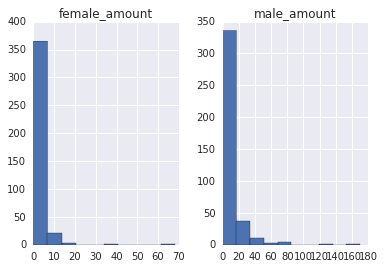

In [211]:
%pylab inline
df.hist()

(0, 25)

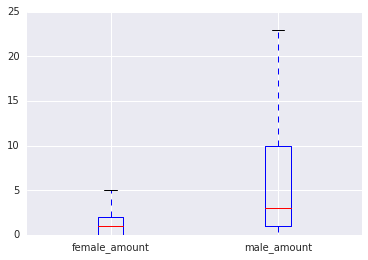

In [212]:
#for all data
g=df.boxplot(return_type='axes')
g.set_ylim(0,25)

In [213]:
import json
def load_simple_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)
words=load_simple_json('de/occupation_all.json')
m_f={i:words[i][1] for i in words}#male:female
data=pd.read_csv("de/wiki/all_wiki_pages.csv",sep='\t', encoding='utf-8',index_col=0) 

f_bias_prop=load_simple_json('de/f_bias_labour.json')
n_bias_prop=load_simple_json('de/n_bias_labour.json')
n_n_bias_prop=load_simple_json('de/n_n_bias_labour.json')
m_bias_prop=load_simple_json('de/m_bias_labour.json')
f_df=pd.DataFrame.from_dict(f_bias_prop)
n_df=pd.DataFrame.from_dict(n_bias_prop)
n_n_df=pd.DataFrame.from_dict(n_n_bias_prop)
m_df=pd.DataFrame.from_dict(m_bias_prop)
all_together = pd.concat([n_df,n_n_df,f_df,m_df],ignore_index=True)
all_together["f_name"]=all_together['name'].map(lambda x: m_f[x] if m_f.has_key(x) else None)
#all_together["other_name"]=all_together['name'].map(lambda x: data. if m_f.has_key(x) else None)
all_together.to_csv("de/all_labour.csv", sep='\t', encoding='utf-8')
all_together[all_together.name=="Audiodesigner"]

,Berufsgruppe,Frauen,KldB,KldB5,Männer,Overall,name,f_name
1,"Musik-,Gesangs-, Dirigententätigk. (ssT)",35.508637,9418,94183,64.491363,521,Audiodesigner,Audiodesignerin


# Female dominated professions

(0, 50)

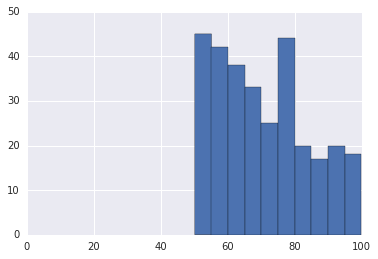

In [214]:
#get where more than 50% of women involved
df_most_f=all_together[all_together.Frauen>=50.0]#308

g=df_most_f.Frauen.hist(bins=10)
g.set_xlim(0,100)
g.set_ylim(0,50)
#df_most_f

In [215]:
#wikipedia page names for 
f_=list(data[data.Name.isin(df_most_f.name)].WikiName.values) #297
f_f=list(data[data.Oppositgender.isin(df_most_f.name)].WikiName.values) #12
f_.extend(f_f)#309
female_most_people=df[df.index.isin(f_)]#145
female_most_people

,male,female_amount,female,male_amount
Abt,"[Leo XIII, Leo X, Papst, Schmitt, Karl Martell...",1,[Martina Wiech],5
Altenpflegehelfer,"[Thomas Klie, Robert, Bernd Hein]",1,[Virginia Guerra],3
Altenpfleger,"[Manfred Engl, Frank Drieschner]",3,"[Brigitte Zellhuber, Annette Riedel, Sonja Sch...",2
Anästhesietechnischer Assistent,"[Martin Bauer, Florian Eckert]",1,[Robin Rüsenberg],2
Apotheker,"[Franz - Josef Kuhlen, Christoph Friedrich, Jo...",1,[Magdalena Meub],26
Arbeitsvermittler,"[Holger Schütze, Anders, Jonas F . Puck, Olive...",2,"[Ma, Henriette Heber]",5
Archivar,"[Michael Diefenbacher, Max Plassmann, Norbert ...",3,"[Julia Brüdegam, Gertrude Cepl, Sabine Brenner]",3
Arzt,"[Bernhard Strauß, Rhys Clement:Mirror, Lothar ...",3,"[Vittoria Bucknall, Kathy Charles, Deborah Mac...",21
Au-pair,"[Georg Beckmann, Volker Schmerse]",10,"[Sabine Hess, Ira Dumpe, Tatjana Eggeling, Dan...",2
Aufsichtsperson,"[Otto von Bismarck, Torsten Welz]",1,[Beck],2


(0, 25)

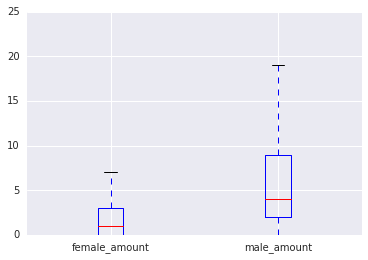

In [216]:
g=female_most_people.boxplot(return_type='axes')
g.set_ylim(0,25)

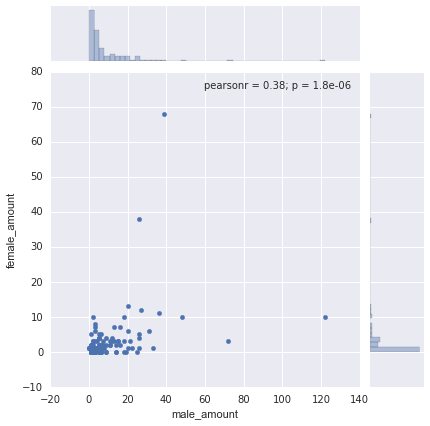

In [217]:
import seaborn as sns
g=sns.jointplot(x="male_amount", y="female_amount", data=female_most_people)

# Male dominated professions

(0, 100)

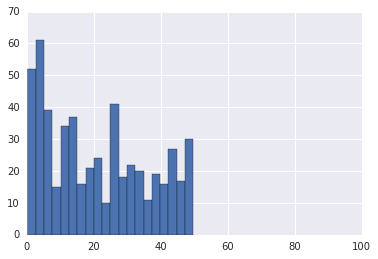

In [218]:
#get other, i.e, most workers are man

df_most_m=all_together[all_together.Frauen<50.0]

g=df_most_m.Frauen.hist(bins=20)
g.set_xlim(0,100)
#g.set_ylim(0,50)

In [219]:
df_most_m#530

,Berufsgruppe,Frauen,KldB,KldB5,Männer,Overall,name,f_name
0,"Obj.Pers.Brandschutz,Arbeitssicherh(ssT)",37.700505,5318,53182,62.299495,8915,Hilfspolizist,Politesse
1,"Musik-,Gesangs-, Dirigententätigk. (ssT)",35.508637,9418,94183,64.491363,521,Audiodesigner,Audiodesignerin
2,"Aufsicht,Führung-TheaterFilm,Fernsehprod",40.187288,9449,94494,59.812712,5019,Filmgeschäftsführer,Filmgeschäftsführerin
4,Berufe für Post- und Zustelldienste,47.894039,5132,51321,52.105961,205963,Bote,Botin
5,"Autoren/Autorinnen, Schriftsteller/innen",47.783251,9243,92434,52.216749,812,Dichter,Dichterin
6,Angehörige gesetzgebender Körperschaften,18.156809,7121,71214,81.843191,2908,Bundeskanzler,Bundeskanzlerin
8,"Berufe Informations,Telekommunikationst.",11.438161,2631,26313,88.561839,191884,Medientechniker,Medientechnikerin
9,"Berufe Informations,Telekommunikationst.",11.438161,2631,26313,88.561839,191884,Projektassistent,Projektassistentin
13,Berufe in der Landwirtschaft (o.S.),21.576590,1110,11101,78.423410,124357,Knecht,Magd
15,Berufe in der Bautischlerei,2.720148,3333,33332,97.279852,23859,Messebauer,Messebauerin


In [220]:
#wikipedia page names for male dominated professions
m_=list(data[data.Name.isin(df_most_m.name)].WikiName.values) #529
m_m=list(data[data.Oppositgender.isin(df_most_m.name)].WikiName.values) #6
m_.extend(m_m)#535
male_most_people=df[df.index.isin(m_)]#236
male_most_people

,male,female_amount,female,male_amount
Abfallbeauftragter,"[Schmidt, Stephan, Erich]",0,NaN,3
Anwendungsprogrammierer,[Springer Gabler],0,NaN,1
Architekt,"[Hanno Wolfensberger, Michael O’Shea, Günther ...",7,"[Tanja Kullack, Kristina Lowis, Ulrike Eichhor...",11
Arrangeur,"[Bill Holman, Billy May, Michael Gibson, Claus...",9,"[Dani Felber, Gigi, Mary Lou Williams, Maria S...",81
Artist (Darsteller),"[Hermann Haupt, Roman, Omar Kingsley, Lothar G...",16,"[Mathilde Monnet, Paris o.J, Claire Heliot, Th...",5
Astronom,[Wilhelm Olbers],0,NaN,1
Audiodesign,[Hannes Raffaseder],0,NaN,1
Ausbilder,[Jacobs],0,NaN,1
Automatenfachmann,[Philipp Rösler],0,NaN,1
Ballettrepetitor,"[Siegfried Mauser, Arnold Jacobshagen, Ulrich ...",0,NaN,6


(0, 25)

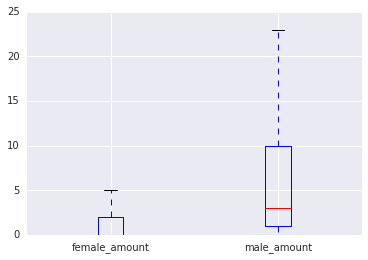

In [221]:
g=male_most_people.boxplot(return_type='axes')
g.set_ylim(0,25)

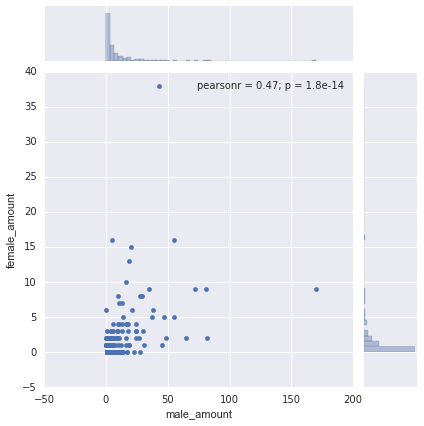

In [222]:
import seaborn as sns
g=sns.jointplot(x="male_amount", y="female_amount", data=male_most_people)

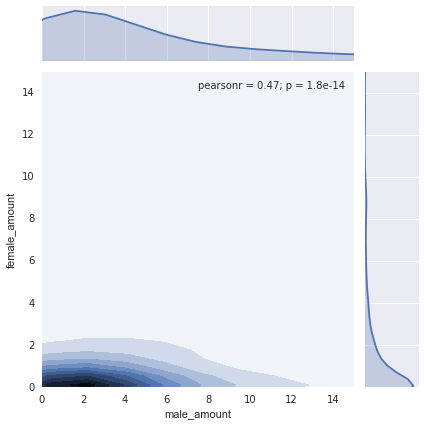

In [223]:
g=sns.jointplot(x="male_amount", y="female_amount",data=male_most_people, kind="kde",xlim=(0,15), ylim=(0,15))

In [224]:
print "No statistical data for these profesions:"
set(set(df.index)-set(m_))-set(f_)

No statistical data for these profesions:


{u'Angestellter',
 u'B\xfcchsenmeister',
 u'Chemisch-Technischer Assistent',
 u'Einrichtungsberater',
 u'Fachkraft',
 u'Fachpraktiker',
 u'Helfer',
 u'Kaufmann',
 u'Sachverst\xe4ndiger',
 u'Sonnenschutztechniker',
 u'Steinhauer',
 u'Trainer'}

# Compare two datasets

### labor market

In [226]:
#male set
male_most_people["m_normalized"]=male_most_people.apply(lambda x: float(x["male_amount"])/float(x["male_amount"] + x["female_amount"]), axis = 1)
#female set
female_most_people["m_normalized"]=female_most_people.apply(lambda x: float(x["male_amount"])/float(x["male_amount"] + x["female_amount"]), axis = 1)
male_most_people["labor_market_domin"]=male_most_people.apply(lambda x: "male",axis=1)#"male"
female_most_people["labor_market_domin"]=female_most_people.apply(lambda x: "female",axis=1)#"female"
#male_most_people.to_csv("de/male_most_polyglot.csv", sep='\t', encoding='utf-8')
#female_most_people.to_csv("de/female_most_polyglot.csv", sep='\t', encoding='utf-8')

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexin

Ratio of male persons in all articles (mean): 0.820068707556


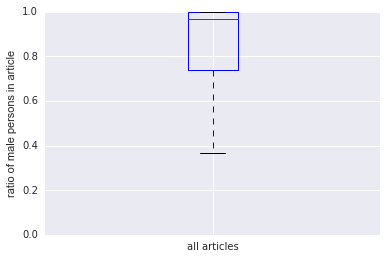

In [234]:
df_all=pd.concat([male_most_people,female_most_people],ignore_index=True)
df_all.boxplot(column="m_normalized",return_type='axes')
plt.xticks([1],["all articles"])
plt.ylabel("ratio of male persons in article")
print "Ratio of male persons in all articles (mean):",df_all.m_normalized.mean()

Ratio of male persons in articles about female dominated profesion(mean): 0.770013463031
Ratio of male persons in articles about male dominated profesion(mean): 0.850822989149


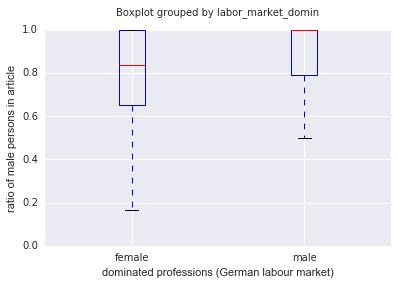

In [235]:
f_val=female_most_people.m_normalized.values
print "Ratio of male persons in articles about female dominated profesion(mean):",female_most_people.m_normalized.mean()
m_val=male_most_people.m_normalized.values
print "Ratio of male persons in articles about male dominated profesion(mean):",male_most_people.m_normalized.mean()

df_all.boxplot(column="m_normalized",return_type='axes',by="labor_market_domin" )
plt.ylabel("ratio of male persons in article")
plt.title("")
plt.xlabel("dominated professions (German labour market)")
plt.show()

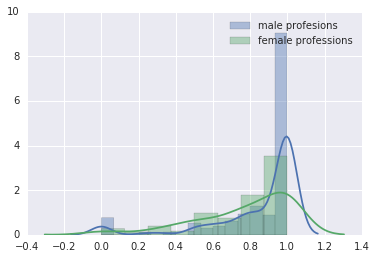

In [164]:
g1=sns.distplot(m_val,label="male profesions")
g2=sns.distplot(f_val,label="female professions")
g2.legend()
#g.set_xlim(0,)

In [165]:
from scipy import stats  
  
z_stat, p_val = stats.ranksums(m_val, f_val)   
print "MWW RankSum P for male and female distributions =", p_val , "z_stat=",z_stat
all_together=list(m_val)+ list(f_val)
z_stat, p_val = stats.ranksums(all_together, m_val)  
print "MWW RankSum P for all together and female distributions =", p_val ,"z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, f_val)  
print "MWW RankSum P for all together and male distributions =", p_val  , "z_stat=",z_stat

MWW RankSum P for male and female distributions = 0.00017610860633 z_stat= 3.75103144924
MWW RankSum P for all together and female distributions = 0.0688622605544 z_stat= -1.81932238261
MWW RankSum P for all together and male distributions = 0.0119556051963 z_stat= 2.51345198287


| | p-val | z |
| :-|:-:|:-:|
| male professions & female professions |    0.000     |   3.75    | 
| all_together & female profession |     0.06    |     -1.82    | 
| all_together & male profession |     0.012    |     2.51    | 

### Bias

2 354 37


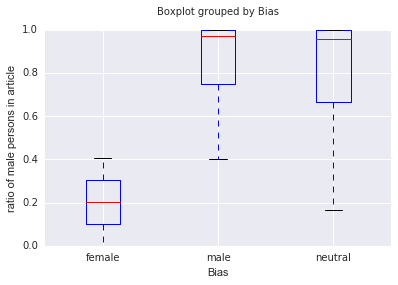

In [181]:
df["Bias"]=df.apply(lambda x: data[data.WikiName.isin([x.name])].Bias.values[0], axis =1)
df["m_normalized"]=df.apply(lambda x: float(x["male_amount"])/float(x["male_amount"] + x["female_amount"]), axis = 1)

print len(df[df.Bias=="female"]),len(df[df.Bias=="male"]),len(df[df.Bias=="neutral"])

g=df.boxplot(by='Bias',column="m_normalized", return_type="axes")
plt.ylabel("ratio of male persons in article")
plt.title("")
plt.show()

In [168]:
#significance test
from scipy import stats  

m_val=df[df.Bias=="male"].m_normalized.values
f_val=df[df.Bias=="female"].m_normalized.values
n_val=df[df.Bias=="neutral"].m_normalized.values
z_stat, p_val = stats.ranksums(m_val, f_val)   
print "MWW RankSum P for male and female distributions =", p_val , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(m_val, n_val)   
print "MWW RankSum P for male and neutral distributions =", p_val , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(f_val, n_val)   
print "MWW RankSum P for female and neutral distributions =", p_val , "z_stat=",z_stat
all_together=list(m_val)+ list(f_val)+ list(n_val)
z_stat, p_val = stats.ranksums(all_together, m_val)  
print "MWW RankSum P for all together and male distributions =", p_val ,"z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, f_val)  
print "MWW RankSum P for all together and female distributions =", p_val  , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, n_val)  
print "MWW RankSum P for all together and neutral distributions =", p_val  , "z_stat=",z_stat

MWW RankSum P for male and female distributions = 0.0277034934381 z_stat= 2.20145974541
MWW RankSum P for male and neutral distributions = 0.482859918147 z_stat= 0.701710187982
MWW RankSum P for female and neutral distributions = 0.0385158566153 z_stat= -2.06932225489
MWW RankSum P for all together and male distributions = 0.791500283496 z_stat= -0.264362916716
MWW RankSum P for all together and female distributions = 0.0288435049737 z_stat= 2.18561881429
MWW RankSum P for all together and neutral distributions = 0.55507963706 z_stat= 0.590165592928


### gender of profession label

10 359 24


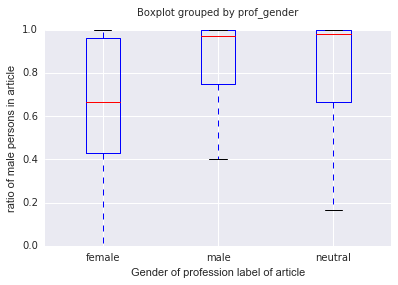

In [182]:
import copy
f_val=load_simple_json('de/wiki/f_page_validated.json')
f_amb=load_simple_json('de/wiki/f_page_ambigious.json')
n_pages=load_simple_json('de/wiki/n_page_validated.json')
n_pages2=data[(data.Bias=="neutral") & (data.Name!=data.WikiName)].WikiName.values#neutral names of professions
n_pages_all=copy.deepcopy(n_pages)
n_pages_all.extend(n_pages2)
f_val_all=copy.deepcopy(f_val)
f_val_all.extend(f_amb)


#add column "profession gender" to DataFrame
def identify_gender(f_val_all,n_pages_all,x):
    if x.name in f_val_all:
        return "female"
    elif x.name in n_pages_all:
        return "neutral"
    else:
        return "male"
df["prof_gender"]=df.apply(lambda x: identify_gender(f_val_all,n_pages_all,x),axis=1)
print len(df[df.prof_gender=="female"]),len(df[df.prof_gender=="male"]),len(df[df.prof_gender=="neutral"])

g=df.boxplot(column="m_normalized",by="prof_gender",return_type='axes')#n=9,n=239,n=9
plt.title("")
plt.ylabel("ratio of male persons in article")
plt.xlabel("Gender of profession label of article")
plt.show()#n=10,n=359 ,n=24

In [178]:
#significance test:

#significance test
from scipy import stats  

m_val=df[df.prof_gender=="male"].m_normalized.values
f_val=df[df.prof_gender=="female"].m_normalized.values
n_val=df[df.prof_gender=="neutral"].m_normalized.values
z_stat, p_val = stats.ranksums(m_val, f_val)   
print "MWW RankSum P for male and female distributions =", p_val , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(m_val, n_val)   
print "MWW RankSum P for male and neutral distributions =", p_val , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(f_val, n_val)   
print "MWW RankSum P for female and neutral distributions =", p_val , "z_stat=",z_stat
all_together=list(m_val)+ list(f_val)+ list(n_val)
z_stat, p_val = stats.ranksums(all_together, m_val)  
print "MWW RankSum P for all together and male distributions =", p_val ,"z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, f_val)  
print "MWW RankSum P for all together and female distributions =", p_val  , "z_stat=",z_stat
z_stat, p_val = stats.ranksums(all_together, n_val)  
print "MWW RankSum P for all together and neutral distributions =", p_val  , "z_stat=",z_stat

MWW RankSum P for male and female distributions = 0.0605117518364 z_stat= 1.87704627481
MWW RankSum P for male and neutral distributions = 0.723166662661 z_stat= 0.354229813039
MWW RankSum P for female and neutral distributions = 0.198764606373 z_stat= -1.28507920823
MWW RankSum P for all together and male distributions = 0.785316617922 z_stat= -0.272397209739
MWW RankSum P for all together and female distributions = 0.0702435316588 z_stat= 1.81033707037
MWW RankSum P for all together and neutral distributions = 0.790869198358 z_stat= 0.265182080787


# Examples for polyglot usage

In [78]:
#======EXAMPLE
import json
import polyglot
from polyglot.text import Text, Word

#Example1
text = Text(u"In Großbritannien war Gandhi und Arnim mit dem westlichen Lebensstil vertraut geworden. Olga Zagovora war nett.")
print("Language Detected: Code={}, Name={}\n".format(text.language.code, text.language.name))
print("{:<16}{}".format("Word", "POS Tag")+"\n"+"-"*30)
for word, tag in text.pos_tags:
    print(u"{:<16}{:>2}".format(word, tag))
    
#Example 2   
#with open('de/wiki/all_data_from pages.json', 'r') as in_f:
#    Dump=json.load(in_f)
    
raw_text=Dump["Abfallbeauftragter"]["text"]
raw_text_1st_sentence=raw_text.split(".",1)[0].encode("utf-8").decode("utf-8")
print raw_text_1st_sentence
text = Text(raw_text_1st_sentence)
#?text.pos_tags   
print("Language Detected: Code={}, Name={}\n".format(text.language.code, text.language.name))
print text.language,type(text.language)
print polyglot.detect.base.Language(["Deutsch", "de", 99.0, 1205])
print polyglot.detect.base.Language.from_code("de")
#set the language
text._BaseBlob__lang=polyglot.detect.base.Language.from_code("de")#Text("Abfallbeauftragter").language
print text.language,type(text.language)
print("Language Detected: Code={}, Name={}\n".format(text.language.code, text.language.name))
print("{:<16}{}".format("Word", "POS Tag")+"\n"+"-"*30)
for word, tag in text.pos_tags:
    print(u"{:<16}{:>2}".format(word, tag))
#print(text.entities)
all_names=text.entities
list_of_personal_names=[]
for t in text.entities:
    if t.tag=="I-PER":
        list_of_personal_names.append(t[0] if len(t)==1 else " ".join(i for i in t))
print list_of_personal_names


Language Detected: Code=de, Name=Deutsch

Word            POS Tag
------------------------------
In              PROPN
Großbritannien  PROPN
war             PROPN
Gandhi          PROPN
und             PROPN
Arnim           PROPN
mit             PROPN
dem             PROPN
westlichen      ADJ
Lebensstil      NOUN
vertraut        ADJ
geworden        ADJ
.               PROPN
Olga            PROPN
Zagovora        PROPN
war             PROPN
nett            ADJ
.               PROPN
Ein Abfallbeauftragter oder Betriebsbeauftragter für Abfall berät den Unternehmer oder Betreiber einer Anlage und die Betriebsangehörigen in Angelegenheiten, die für die Kreislaufwirtschaft und die Abfallbeseitigung bedeutsam sein können
Language Detected: Code=de, Name=Deutsch

name: Deutsch     code: de       confidence:  99.0 read bytes:  1205 <class 'polyglot.detect.base.Language'>
name: Deutsch     code: de       confidence:  99.0 read bytes:  1205
name: Deutsch     code: de       confidence: 100.0 read by

In [2]:
#=====Download this before polyglot usage=====
from polyglot.downloader import downloader
downloader.supported_tasks(lang="de")
downloader.download("embeddings2.de")
downloader.download("pos2.de")
downloader.download("ner2.de")
#=========================

[polyglot_data] Downloading package ner2.de to C:\Anaconda\Lib\site-
[polyglot_data]     packages\polyglot\data...


True

# Stanford approach==> Does not work

In [6]:
import nltk
from nltk.tag.stanford import NERTagger
nltk.internals.config_java("C:\\Java\\jdk1.8.0_25\\bin\\java.exe")#jre1.8.0_66
path_to_model ="C:\Users\Lelka\Downloads\stanford-ner-2015-12-09\stanford-ner-2015-12-09\classifiers\english.all.3class.distsim.crf.ser.gz"
path_to_jar = "C:\Users\Lelka\Downloads\stanford-ner-2015-12-09\stanford-ner-2015-12-09\stanford-ner-3.6.0.jar"
st = NERTagger(path_to_model,path_to_jar)#, 'stanford-ner/stanford-ner.jar')
#st = NERTagger("C:\Users\Lelka\Downloads\stanford-german-2015-10-14-models.jar",
#               "C:\Users\Lelka\Downloads\stanford-ner-2015-12-09\stanford-ner-2015-12-09\stanford-ner.jar")
#download from http://nlp.stanford.edu/software/CRF-NER.html

#st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz')

#from nltk.tag import StanfordPOSTagger
#st = StanfordPOSTagger('english-bidirectional-distsim.tagger') 
text = """YOUR TEXT GOES HERE"""

for sent in nltk.sent_tokenize(text):
    tokens = nltk.tokenize.word_tokenize(sent)
    tags = st.tag(tokens)
    for tag in tags:
        if tag[1]=='PERSON': print tag

[Found C:\Java\jdk1.8.0_25\bin\java.exe: C:\Java\jdk1.8.0_25\bin\java.exe]
CRFClassifier invoked on Thu Mar 03 01:54:17 CET 2016 with arguments:
   -loadClassifier C:\Users\Lelka\Downloads\stanford-ner-2015-12-09\stanford-ner-2015-12-09\classifiers\english.all.3class.distsim.crf.ser.gz -textFile c:\users\lelka\appdata\local\temp\tmptwpxy4 -outputFormat slashTags
loadClassifier=C:\Users\Lelka\Downloads\stanford-ner-2015-12-09\stanford-ner-2015-12-09\classifiers\english.all.3class.distsim.crf.ser.gz
textFile=c:\users\lelka\appdata\local\temp\tmptwpxy4
outputFormat=slashTags
Exception in thread "main" java.lang.NoClassDefFoundError: org/slf4j/LoggerFactory
	at edu.stanford.nlp.io.IOUtils.<clinit>(IOUtils.java:42)
	at edu.stanford.nlp.ie.AbstractSequenceClassifier.loadClassifier(AbstractSequenceClassifier.java:1484)
	at edu.stanford.nlp.ie.AbstractSequenceClassifier.loadClassifierNoExceptions(AbstractSequenceClassifier.java:1497)
	at edu.stanford.nlp.ie.crf.CRFClassifier.main(CRFClassifier

OSError: Java command failed!

In [6]:
from nltk.parse.stanford import StanfordParser
from nltk.parse.stanford import StanfordDependencyParser
from nltk.parse.stanford import StanfordNeuralDependencyParser
from nltk.tag.stanford import StanfordPOSTagger, StanfordNERTagger
from nltk.tokenize.stanford import StanfordTokenizer

In [79]:
from nltk.tag.stanford import StanfordPOSTagger
st = StanfordPOSTagger('english-bidirectional-distsim.tagger')

LookupError: 

===========================================================================
  NLTK was unable to find stanford-postagger.jar! Set the CLASSPATH
  environment variable.

  For more information, on stanford-postagger.jar, see:
    <http://nlp.stanford.edu/software>
===========================================================================

In [2]:
import nltk
from nltk.tag import StanfordNERTagger
#nltk.internals.config_java("C:\\Java\\jdk1.8.0_73\\bin\\java.exe")
st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz',
                       path_to_jar="c:\stanford\stanford-ner-2015-12-09\stanford-ner-3.6.0.jar") 
st.tag('Rami Eid is studying at Stony Brook University in NY'.split())

CRFClassifier invoked on Thu Mar 03 14:40:03 CET 2016 with arguments:
   -loadClassifier C:\Stanford\stanford-ner-2015-12-09\classifiers\english.all.3class.distsim.crf.ser.gz -textFile c:\users\zagovooa\appdata\local\temp\tmpmepzqe -outputFormat slashTags -tokenizerFactory edu.stanford.nlp.process.WhitespaceTokenizer -tokenizerOptions "tokenizeNLs=false" -encoding utf8
tokenizerFactory=edu.stanford.nlp.process.WhitespaceTokenizer
tokenizerOptions="tokenizeNLs=false"
loadClassifier=C:\Stanford\stanford-ner-2015-12-09\classifiers\english.all.3class.distsim.crf.ser.gz
encoding=utf8
textFile=c:\users\zagovooa\appdata\local\temp\tmpmepzqe
outputFormat=slashTags
Exception in thread "main" java.lang.NoClassDefFoundError: org/slf4j/LoggerFactory
	at edu.stanford.nlp.io.IOUtils.<clinit>(IOUtils.java:42)
	at edu.stanford.nlp.ie.AbstractSequenceClassifier.loadClassifier(AbstractSequenceClassifier.java:1484)
	at edu.stanford.nlp.ie.AbstractSequenceClassifier.loadClassifierNoExceptions(AbstractSequ

OSError: Java command failed : ['C:\\Java\\jdk1.8.0_73\\bin\\java.exe', '-mx1000m', '-cp', 'c:\\stanford\\stanford-ner-2015-12-09\\stanford-ner-3.6.0.jar', 'edu.stanford.nlp.ie.crf.CRFClassifier', '-loadClassifier', 'C:\\Stanford\\stanford-ner-2015-12-09\\classifiers\\english.all.3class.distsim.crf.ser.gz', '-textFile', 'c:\\users\\zagovooa\\appdata\\local\\temp\\tmpmepzqe', '-outputFormat', 'slashTags', '-tokenizerFactory', 'edu.stanford.nlp.process.WhitespaceTokenizer', '-tokenizerOptions', '"tokenizeNLs=false"', '-encoding', 'utf8']